# Analysing the accuracy of Fandango's movie ratings

In October 2015, a data journalist named Walt Hickey from FiveThirtyEight analyzed [movie ratings data](https://fivethirtyeight.com/features/fandango-movies-ratings/) and found strong evidence to suggest that Fandango's rating system was biased, generally displaying higher ratings than what the movie actually received.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. In this project, we'll compare Fandango's data from Hickey's analysis and from movies released in 2016 & 2017 to determine whether there has been any change in Fandango's rating system.

Both datasets are available on Github:
- [Hickey's data](https://github.com/fivethirtyeight/data/tree/master/fandango)
- [2016 & 2017 data](https://github.com/mircealex/Movie_ratings_2016_17)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## Exploring the data and selecting what we need

In [3]:
# reading in Hickey's data
fandango = pd.read_csv('fandango_score_comparison.csv')
# reading in the data for movies released in 2016 and 2017
ratings1617 = pd.read_csv('movie_ratings_16_17.csv')

After reading the data into dataframes and exploring the data, we know that the Fandango data has 146 rows and 22 columns consisting of ratings information from various sources. 

The data on movie ratings from 2016 and 2017 has 214 rows and 15 columns with ratings info from similar sources. However, the data is stored in columns with different names.

Both sources have a combination of strings, integers and floats, and do not have any null values.

Now we'll select the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in.

In [4]:
fandango_subset = fandango[['FILM','Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
ratings_subset = ratings1617[['movie', 'year', 'fandango']].copy()


The fandango dataset contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango as of  24 August 2015.

The other ratings data set contains movie ratings data for 214 of the most popular movies (with a significant number of votes, but the exact number is unspecified) released in 2016 and 2017, and is accurate as of 22 March 2017. 

The data come from the periods of time that we need - before and after Hickey's analysis, respectively. However, the sampling is not random and the samples were created based on the authors' purpose. They are also unlikely to be representative of the population of movie reviews on Fandango, as they represent subsets of movies released and reviewed at specific points in time.

### Changing the goal of this analysis

As the data is not representative of what we were planning to analyse - Fandango's movie rating system - we will change the goal of our analysis by placing some limitations on it.

We'll focus on determining whether there has been any change in Fandango's rating system for movies with a significant number of votes/reviews by comparing those released in 2015 with those released in 2016 and 2017. This should still be a relatively good proxy for movies released before and after Hickey's analysis.

We'll use the minimum of 30 fan ratings in Hickey's dataset as the minimum to be considered a "significant number". However, as the 2nd dataset doesn't provide info about how many fan reviews each movie has, we'll select a random sample of 12 movies. If at least 9 of them have 30 or more fan reviews then we'll proceed to use the data as it is.

In [5]:
ratings_subset.sample(12, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As of 2 Feb 2022, the number of fan ratings for each of the movies is as follows.

| Movie | Fan ratings | 
| --- | --- | 
| Mechanic: Resurrection | 25,672 | 
| Warcraft | 31,814 |
| Max Steel | 6,874|
| Me Before You | 30,827 |
| Fantastic Beasts and Where to Find Them | 88,321 |
| Cell| 180,919 |
| Genius | 12 |
| Sully | 48,723 |
| A Hologram for the King | 10,266 |
| Captain America: Civil War | 185,188 |
| Mr. Church | 4,714 |
| Crouching Tiger, Hidden Dragon: Sword of Destiny | 12,119 |

11 out of 12 have more than 30 fan ratings, so we should be able to proceed with the data that we have.

In [6]:
fandango[fandango['Fandango_votes']<30]

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference


We have also confirmed that there are no movies <30 fan ratings in the 2015 dataset.

### Isolating movies from 2015, 2016 and 2017

In [7]:
# Extracting years from the FILM column in Hickey's data
fandango_subset['year'] = fandango_subset['FILM'].str[-5:-1]
fandango_subset.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [8]:
# Only selecting films released in 2015
print(fandango_subset['year'].value_counts())
fandango_2015 = fandango_subset[fandango_subset['year']=='2015']
fandango_2015.shape

2015    129
2014     17
Name: year, dtype: int64


(129, 6)

We retained 129 out of 146 movies as 17 of them were released in 2014.

In [9]:
# Checking years of release for 2nd dataset
print(ratings_subset['year'].value_counts())

2016    191
2017     23
Name: year, dtype: int64


As there are only movies released in 2016 and 2017, we don't need to filter the data further.

## Looking at the distributions of movie ratings

We'll start with a simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples

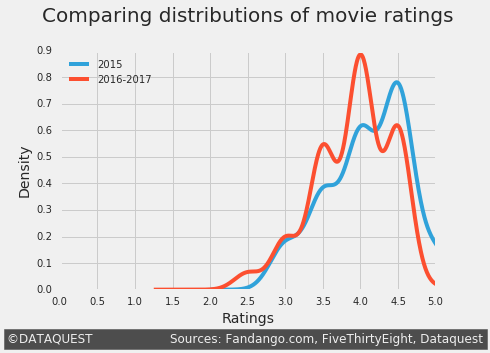

In [82]:
plt.style.use('fivethirtyeight')
fandango_2015['Fandango_Stars'].plot.kde(label='2015',legend=True)
ratings_subset['fandango'].plot.kde(label='2016-2017',legend=True)
plt.xlabel('Ratings',size=14)
plt.ylabel('Density',size=14)
plt.xlim(0,5)
plt.xticks(np.arange(0,5.1,0.5))
plt.title('Comparing distributions of movie ratings', y=1.1,size=20)
plt.text(-0.7, -0.2, '©DATAQUEST' + ' '*20 + 'Sources: Fandango.com, FiveThirtyEight, Dataquest',
        color = '#f0f0f0', backgroundcolor = '#4d4d4d',
       size=12)
plt.show()

Both distributions are skewed left, but the 2015 ratings are slightly highger. The 2015 rating with the highest density if 2.5, while ratings of 4.0 have the highest density for the movies released in 2016 & 2017. This suggests that Fandango may have corrected the rounding logic that it attributed to an error after Hickey's analysis was published, though it is impossible to verify this as the actual ratings have been removed from the HTML code.

## Analysing frequency distribution tables

Now we'll do more granular analysis by looking at the frequency distribution tables of the 2 samples. We'll do this by comparing frequencies in percentages, as both samples contain different numbers of movies.

In [11]:
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [12]:
ratings_subset['fandango'].value_counts(normalize = True).sort_index() * 100


2.5     2.803738
3.0     8.411215
3.5    23.364486
4.0    38.317757
4.5    26.635514
5.0     0.467290
Name: fandango, dtype: float64

From the frequency distribution tables, we can see that most movies are rated between 4-4.5 stars in both samples (about 66.6% in 2015 compared to about 64.9% in 2016-2017). However, the distributions also differ in the following ways:

- Ratings in 2016-2017 have a wider distribution, with 2.8% of ratings below 3 stars compared to none below 3 stars in 2015
- More movies were given lower ratings in 2016-2017 - about 8% more movies are rated 3 stars and below
- A much smaller percentage of movies in 2016-2017 are rated 5 stars, about 0.5% compared to about 7% in 2015
- Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

About 6% more movies were given ratings of 3.5-4 stars in 2016-2017. As these are still high ratings, it suggests that despite the change in distributions, overall movie ratings are still high.

These observations are similar to what we observe in the kernel density plots.

## Looking at summary statistics

We confirmed with the two tables before that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots. As such, we'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [52]:
# computing the mean, median and mode for 2015 data
mean_2015 = fandango_2015['Fandango_Stars'].mean()
median_2015 = fandango_2015['Fandango_Stars'].median()
mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]


In [53]:
# computing the mean, median and mode for 2016-2017 data
mean_aft = ratings_subset['fandango'].mean()
median_aft = ratings_subset['fandango'].median()
mode_aft = ratings_subset['fandango'].mode()[0]


In [54]:
# Storing both sets of summary statistics in dataframes
stats = ['mean','median','mode']
stats_2015 = [mean_2015, median_2015, mode_2015]
stats_aft = [mean_aft, median_aft, mode_aft]

summary = pd.DataFrame(
    {'2016-17': stats_aft
     ,'2015': stats_2015,
    })
summary.index = ['mean', 'median', 'mode']

In [55]:
summary

,2015,2016-17
mean,4.085271,3.89486
median,4.000000,4.00000
mode,4.500000,4.00000


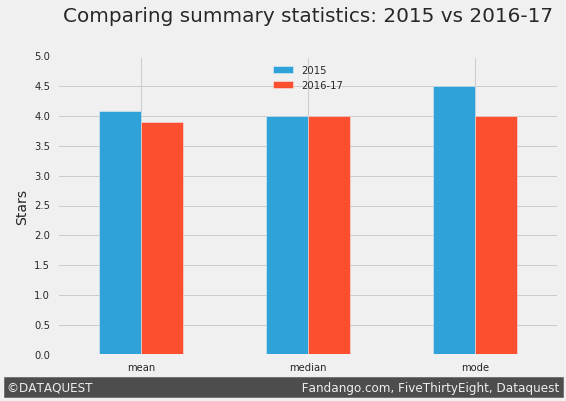

In [86]:
plt.style.use('fivethirtyeight')
summary.plot.bar(legend=True,figsize=(8,5))
plt.ylabel('Stars',size=14)
plt.xticks(rotation=0)
plt.ylim(0,5)
plt.yticks(np.arange(0,5.1,0.5))
plt.legend(loc='upper center')
plt.title('Comparing summary statistics: 2015 vs 2016-17',y=1.1,size=20)
plt.text(-0.8, -0.6, '©DATAQUEST' + ' '*54 + 'Fandango.com, FiveThirtyEight, Dataquest',
        color = '#f0f0f0', backgroundcolor = '#4d4d4d',
       size=12)
plt.show()

Looking at the values in the summary dataframe and at the grouped bar plot, ratings for popular movies in 2015 were slightly higher. Mean ratings were about 0.2 stars higher, while the most common rating was 4.5 stars compared to 4 stars in 2016-2017. However, the median rating was the same in both samples, supporting the observation that ratings in 2015 are only slightly higher.

## Conclusion

Based on our analysis, it is clear that popular movies were rated slightly higher in 2015 compared to 2016 and part of 2017. It is likely that this was due to Fandango fixing the biased rating system after Hickey's analysis.